In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot.inputs.keras import PlotLossesCallback
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten,Conv2D, MaxPooling2D,Dropout, LeakyReLU, BatchNormalization, Input, Reshape, GlobalAveragePooling2D
import warnings
import os
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc
import seaborn as sns

In [2]:
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=90,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                   preprocessing_function = preprocess_input) # VGG16 preprocessing

test_datagen = ImageDataGenerator(rescale=1/255.,
                                  preprocessing_function = preprocess_input) # VGG16 preprocessing

In [3]:
class_subset = sorted(os.listdir('train')) # classes list

In [4]:
train_generator = train_datagen.flow_from_directory('train',
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

valid_generator = train_datagen.flow_from_directory('train',
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory('test',
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 4420 images belonging to 2 classes.
Found 780 images belonging to 2 classes.
Found 1416 images belonging to 2 classes.


In [5]:
# Get the class indices
class_indices = train_generator.class_indices

# Print the class indices
print("Class Indices:", class_indices)

# Inverse the dictionary to map indices to class names
inverse_class_indices = {v: k for k, v in class_indices.items()}

# Print the mapping
print("Class 0:", inverse_class_indices[0])
print("Class 1:", inverse_class_indices[1])

Class Indices: {'Fraud': 0, 'Non-Fraud': 1}
Class 0: Fraud
Class 1: Non-Fraud


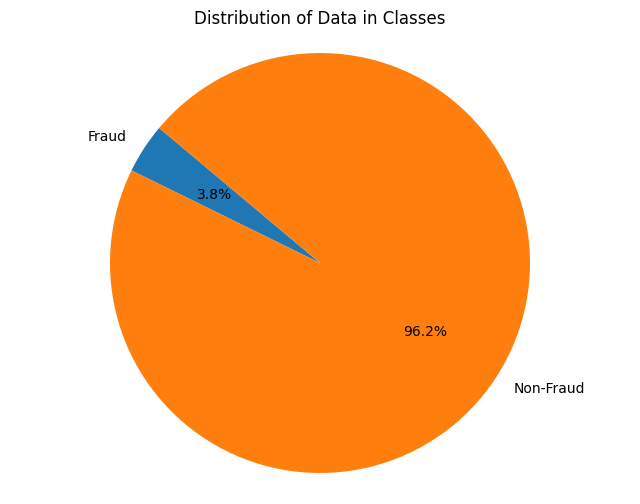

In [6]:
# Count the number of samples in each class
class_counts = np.bincount(train_generator.classes) + np.bincount(valid_generator.classes)

# Define class names
class_names = ['Fraud', 'Non-Fraud']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Data in Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1.]


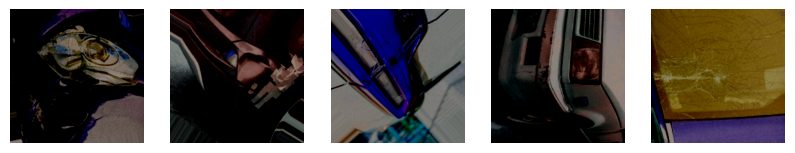

In [7]:
# Generate a batch of augmented images
augmented_images, _ = next(train_generator)
print(_)
# Plot the first 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [8]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=2

In [9]:
n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = valid_generator.samples // BATCH_SIZE
n_epochs = 50

In [10]:
n_steps, n_val_steps

(138, 24)

In [11]:
# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False

# Define the input and output of the base model
input = base_model.input
x = base_model.output

# Flatten or pool the output of the base model
x = GlobalAveragePooling2D()(x)  # You can use Flatten or GlobalAveragePooling2D, depending on your requirements

# Add Dense layers with LeakyReLU, Dropout, and BatchNormalization
x = Dense(2048, activation='relu')(x)

x = Dense(2048, activation='relu')(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input, outputs=output)


In [12]:
model.compile(optimizer=optim_1, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,963,713 (76.16 MB)

 Trainable params: 5,249,025 (20.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
save_name = 'VGG_Linear_2_relu'

In [15]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath=f'models/{save_name}.weights.best.keras',
                                  save_best_only=True,
                                  verbose=1)

In [16]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [17]:
vgg_history = model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9645 - loss: 0.2088 - precision: 0.9646 - recall: 1.0000 
Epoch 1: val_loss improved from inf to 0.14121, saving model to models/VGG_Linear_2_relu.weights.best.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 1521s 11s/step - accuracy: 0.9645 - loss: 0.2085 - precision: 0.9646 - recall: 1.0000 - val_accuracy: 0.9622 - val_loss: 0.1412 - val_precision: 0.9622 - val_recall: 1.0000
Epoch 2/50
  1/138 ━━━━━━━━━━━━━━━━━━━━ 3:58 2s/step - accuracy: 0.9375 - loss: 0.2039 - precision: 0.9375 - recall: 1.0000
Epoch 2: val_loss improved from 0.14121 to 0.04940, saving model to models/VGG_Linear_2_relu.weights.best.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9375 - loss: 0.1027 - precision: 0.9375 - recall: 1.0000 - val_accuracy: 0.9167 - val_loss: 0.0494 - val_precision: 0.9167 - val_recall: 1.0000
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9634 - loss: 0.1361 - precision: 0.9637 - recall: 0.9996
Epoch 3:

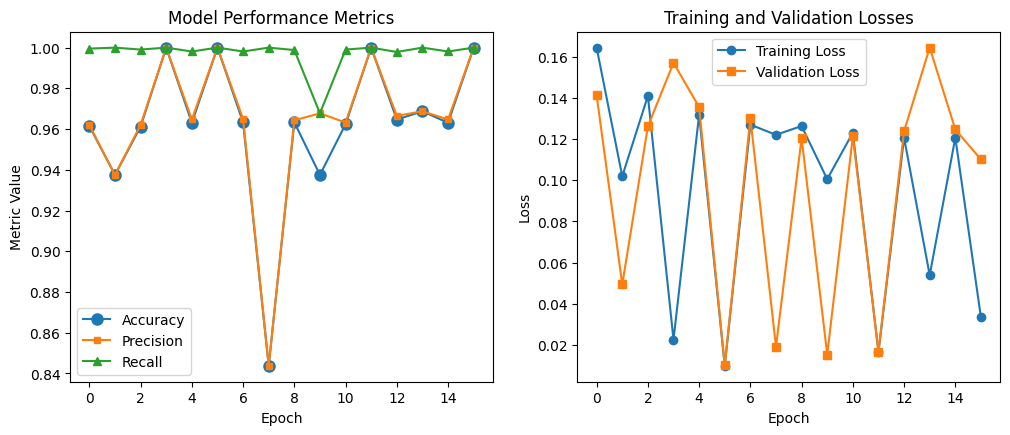

In [18]:
# Plotting with markers
plt.figure(figsize=(12, 10))

# First plot: Model performance metrics
plt.subplot(2, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Accuracy', marker='o', markersize=8)
plt.plot(vgg_history.history['precision'], label='Precision', marker='s', markersize=5)
plt.plot(vgg_history.history['recall'], label='Recall', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Performance Metrics')
plt.legend()

# Second plot: Training and validation losses
plt.subplot(2, 2, 2)
plt.plot(vgg_history.history['loss'], label='Training Loss', marker='o')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Save and show the plot
plt.savefig(f'graphs/{save_name}.png')
plt.show()

In [19]:
# Generate predictions
model = load_model(f'models/{save_name}.weights.best.keras')
true_classes = test_generator.classes
vgg_preds = model.predict(test_generator)

1416/1416 ━━━━━━━━━━━━━━━━━━━━ 206s 145ms/step


In [42]:
vgg_pred_classes = (vgg_preds > 0.5).astype(int)  # Threshold at 0.5

In [43]:
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("Model Accuracy: {:.2f}%".format(vgg_acc * 100))

Model Accuracy: 93.43%


In [44]:
vgg_pred = precision_score(true_classes, vgg_pred_classes)
print("Model Precision: {:.2f}%".format(vgg_pred * 100))

Model Precision: 93.43%


In [45]:
vgg_rec = recall_score(true_classes, vgg_pred_classes)
print("Model Recall: {:.2f}%".format(vgg_rec * 100))

Model Recall: 100.00%


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.93      1.00      0.97      1323

    accuracy                           0.93      1416
   macro avg       0.47      0.50      0.48      1416
weighted avg       0.87      0.93      0.90      1416



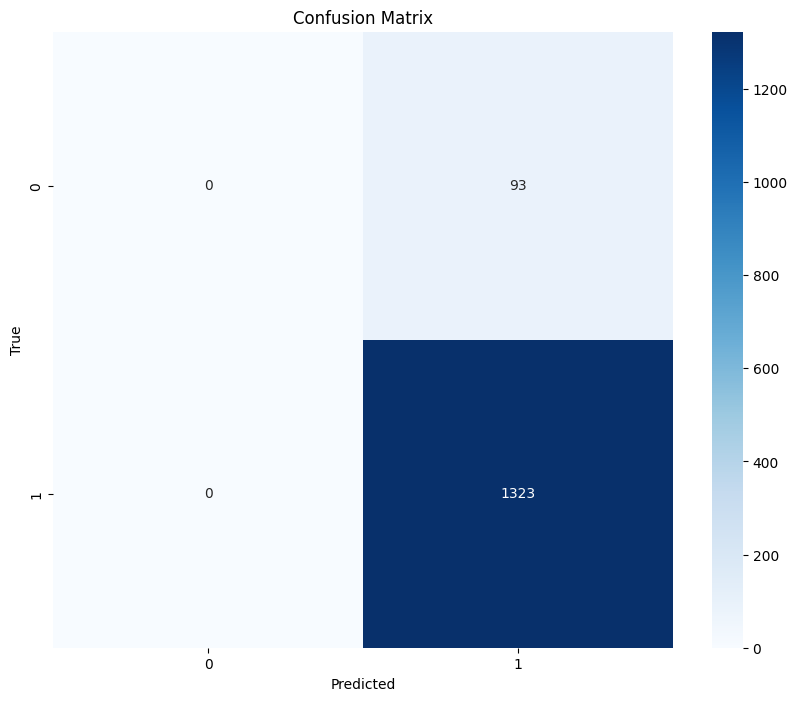

In [46]:
# Print classification report
print("Classification Report:")
print(classification_report(true_classes, vgg_pred_classes))

# Compute confusion matrix
conf_mat = confusion_matrix(true_classes, vgg_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_indices.values(), 
            yticklabels=class_indices.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()